### Step 2 ML Risk Score Prediction Pipeline
**Author:** Evan Yip <br>
**Purpose:** The primary purpose of this notebook is to train the best ML model that can predict our calculated risk score based on features such as demographics, ODI, ADI, and DOSPERT.

In [1]:
# Standard library imports
import ast
import pickle
import os

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

##########################################################################################
#######       Set the current working directory to the root of your project     ##########
os.chdir("/Users/evan/Documents/School/MSDS/msds-capstone/vm-spinal-risk/vm-spinal-risk/")
##########################################################################################

# Setting seaborn theme and pandas display option
sns.set_theme()
pd.set_option('display.max_columns', 50)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Loading and splitting the processed data

In [17]:

data = pd.read_csv("./data/data_processed/ml_data_processed_final.csv")

X = data.drop(['spinal_risk_score'], axis=1)  # All columns except the last one are predictors
y = data['spinal_risk_score'].to_numpy()   # The last column is the response variable

# Dropping additional columns
# Height was chosen 
X = X.drop(['num__height_m', 'num__ADI_STATERNK'], axis=1)

In [18]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
# Splitting the data into a train and validation split
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

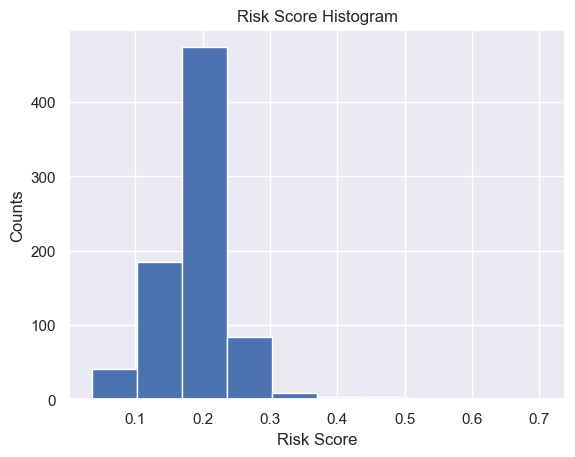

In [6]:
plt.hist(y)
plt.xlabel('Risk Score')
plt.ylabel('Counts')
plt.title('Risk Score Histogram')
plt.show()

### Baseline Linear Regression Models

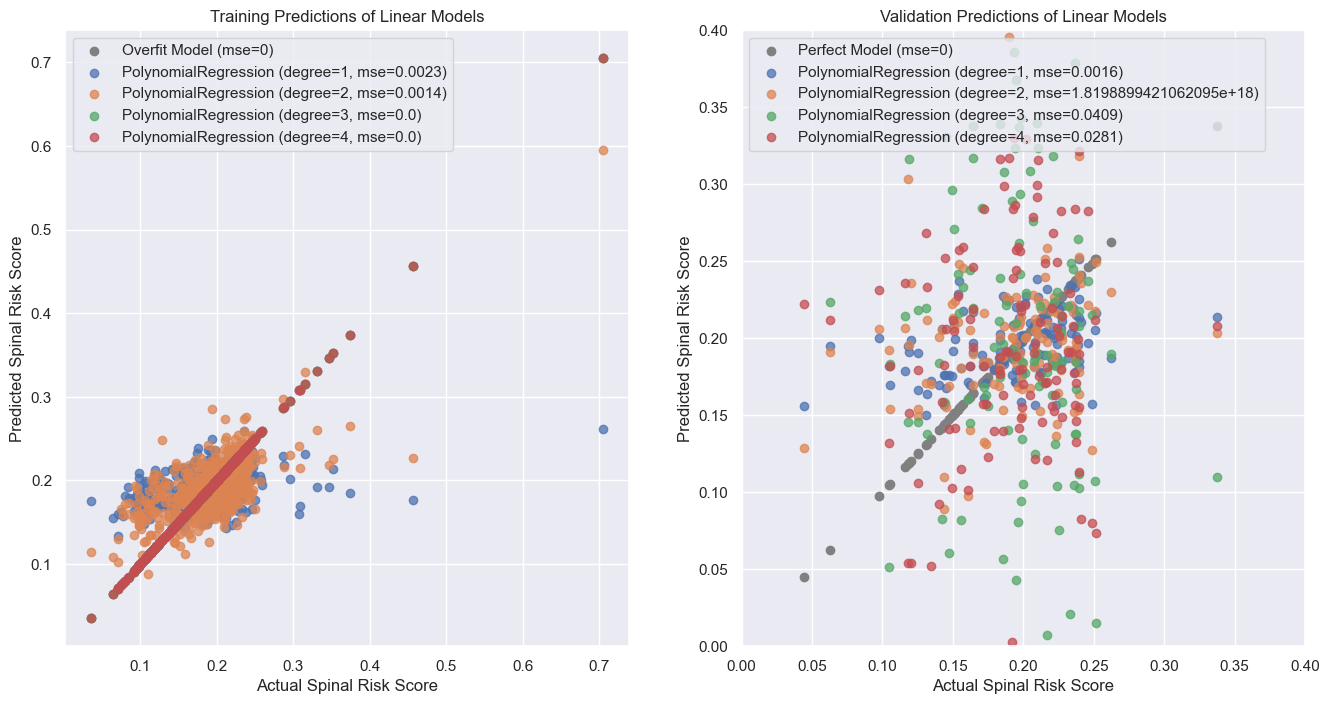

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(y_train2, y_train2, c='gray', label='Overfit Model (mse=0)')
axes[1].scatter(y_val, y_val, c='gray', label='Perfect Model (mse=0)')

# Linear Models
# Polynomial Regression
for degree in range(1, 5):
    polyreg_model = Pipeline([
                    # ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree)),
                    ('linear', LinearRegression(fit_intercept=False))])
    # fit to an order-3 polynomial data
    polyreg_model = polyreg_model.fit(X_train2, y_train2)

    y_train_pred = polyreg_model.predict(X_train2)
    y_val_pred = polyreg_model.predict(X_val)
    
    train_mse = mean_squared_error(y_train_pred, y_train2)
    val_mse = mean_squared_error(y_val_pred, y_val)

    axes[0].scatter(y_train2, y_train_pred, label=f'PolynomialRegression (degree={degree}, mse={np.round(train_mse, 4)})', alpha=0.75)
    axes[1].scatter(y_val, y_val_pred, label=f'PolynomialRegression (degree={degree}, mse={np.round(val_mse, 4)})', alpha=0.75)

axes[0].set_xlabel("Actual Spinal Risk Score")
axes[0].set_ylabel("Predicted Spinal Risk Score")
axes[0].set_title(f"Training Predictions of Linear Models")
axes[0].legend(loc='upper left')


axes[1].set_xlim(0, 0.4)
axes[1].set_ylim(0, 0.4)
axes[1].set_xlabel("Actual Spinal Risk Score")
axes[1].set_ylabel("Predicted Spinal Risk Score")
axes[1].set_title(f"Validation Predictions of Linear Models")
axes[1].legend(loc='upper left')
plt.show()

### Model search and Hyperparameter tuning

In the next cells, I will be testing 8 different types of regression models and performing a random cross validation search of the hyperparameter space. Additionally I will evaluate between either features with a degree 1 or with a polynomial transformation of degree 2. The results of each fold will be saved with the hyperparameters into `../data/model_training/polydegree1` and `../data/model_training/polydegree2` folders. 

In [7]:
#######################
search_method = 'random' # Whether to use random search or grid search
degree = 2 # Defines the polynomial transformation to use
#######################

# Define models
models = {
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'XGBoost Regression': XGBRegressor(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'SVM Regression': SVR(),
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Decision Tree Regression': {
        'max_depth': list(np.arange(10, 110, 10)),
        'min_samples_split': np.arange(2, 20, 1),   # 2 to 20, 1
        'min_samples_leaf': np.arange(1, 11),
        'max_features': list(np.arange(0.1, 1.0, 0.1)),
    },
    'Random Forest Regression': {
        'n_estimators': np.arange(100, 1100, 100),
        'max_depth': list(np.arange(10, 110, 10)),
        'min_samples_split': np.arange(2, 11),
        'min_samples_leaf': np.arange(1, 11),
        'max_features': list(np.arange(0.1, 1.0, 0.1)),
        'bootstrap': [True, False],
    },
    'XGBoost Regression': {
        'n_estimators': np.arange(50, 200, 10),
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'subsample': np.linspace(0.5, 1, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'gamma': np.linspace(0, 0.5, 5),
        'colsample_bytree': np.linspace(0.5, 1, 5)
    },
    'Gradient Boosting Regression': {
        'n_estimators': np.arange(50, 200, 10),
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'min_samples_split': np.arange(2, 20, 1),   # 2 to 20, 1
        'min_samples_leaf': np.arange(1, 20, 1), 
    },
    'SVM Regression': {
        'C': np.linspace(0.5, 20, 30),
        'gamma': np.logspace(start=0, stop=-3, num=4, base=10),
        'kernel': ['linear', 'rbf']
    },
    'Ridge Regression': {
        'alpha': np.logspace(-4, 4, 40),  # Regularization strength
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'Lasso Regression': {
        'alpha': np.logspace(-4, 4, 40),  # Regularization strength
        'max_iter': [1000, 5000, 10000],  # Maximum number of iterations
    },
    'Elastic Net Regression': {
        'alpha': np.logspace(-4, 4, 40),  # Regularization strength
        'l1_ratio': np.linspace(0, 1, 40),  # The ElasticNet mixing parameter
        'max_iter': [1000, 5000, 10000],  # Maximum number of iterations
    },
}
# Perform hyperparameter tuning and model training
predictions = {}
train_predictions = {}
best_models = {}
for model_name, model in models.items():
    if model_name in param_grids:
        if search_method == 'grid':
            # Perform hyperparameter tuning
            grid_search = GridSearchCV(model, param_grids[model_name], cv=6, scoring='neg_mean_squared_error')
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('grid_search', grid_search)
            ])
        else:
            # Perform hyperparameter tuning using RandomizedSearchCV
            randomized_search = RandomizedSearchCV(model, param_grids[model_name], n_iter=300, cv=10, scoring='neg_mean_squared_error', random_state=42)
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('randomized_search', randomized_search)
            ])
    else:
        # No hyperparameter tuning for models without param grids
        pipeline = Pipeline([
            ('model', model)
        ])
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)

    # Accessing the best validation score
    if search_method == 'grid':
        best_validation_score = grid_search.best_score_
    else:
        best_validation_score = randomized_search.best_score_
    best_validation_mse = abs(best_validation_score)  # Convert to positive MSE
    
    print(f'{model_name} - Best Validation Mean Squared Error: {best_validation_mse}')

    # Saving the training predictions and models
    train_predictions[model_name] = y_train_pred
    best_models[model_name] = pipeline

    # Saving the hyperparameters and cross validation results to csv files
    rsearch_df = pd.DataFrame(randomized_search.cv_results_)
    rsearch_df.to_csv(f'./data/model_training/polydegree{degree}/cv_results_{model_name}.csv', index=False)

### Loading in the crossvalidation results 

In [8]:
# Analyzing the results of the random search
degrees = [1, 2]
start = 1
for degree in degrees:
    for model_name in models.keys():
        cv_results = pd.read_csv(f'./data/model_training/polydegree{degree}/cv_results_{model_name}.csv')
        num_rows = cv_results.shape[0]
        cv_results['degree'] = [degree for _ in range(num_rows)]
        cv_results['model_name'] = [model_name for _ in range(num_rows)]
        if start == 1:
            final_cv_results = cv_results
            start = 0
        else:
            final_cv_results = pd.concat([final_cv_results, cv_results], axis=0)

final_cv_results['mean_test_score'] = final_cv_results['mean_test_score'] * -1
final_cv_results = final_cv_results.drop_duplicates(subset=['params', 'model_name', 'degree'])

### Generating summary plots

FixedFormatter should only be used together with FixedLocator


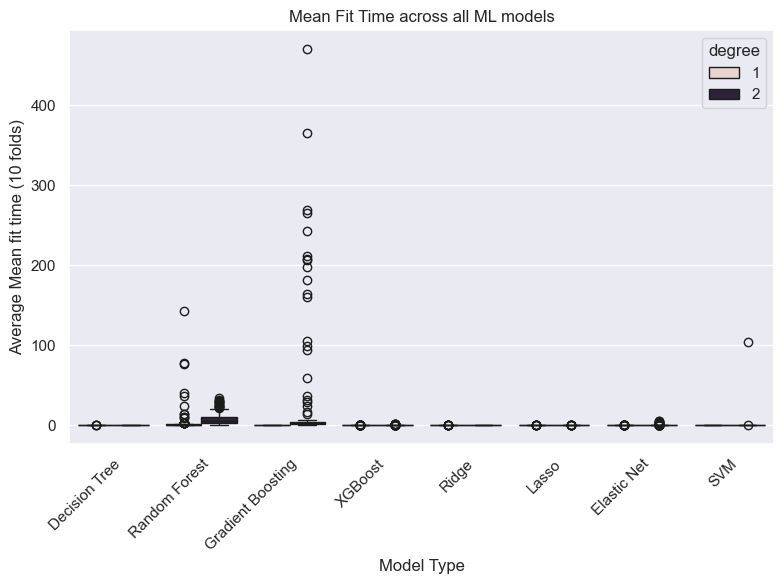

In [9]:
labels = [' '.join(model_name.split(' ')[:-1]) for model_name in final_cv_results['model_name'].unique()]

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(final_cv_results, x='model_name', y='mean_fit_time', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Average Mean fit time (10 folds)')
ax.set_xlabel('Model Type')
ax.set_title('Mean Fit Time across all ML models')
plt.tight_layout()

FixedFormatter should only be used together with FixedLocator


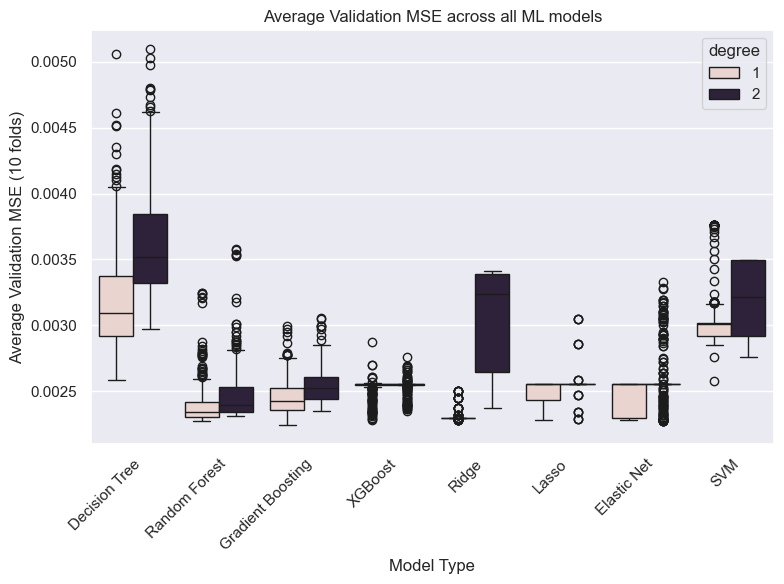

In [10]:
labels = [' '.join(model_name.split(' ')[:-1]) for model_name in final_cv_results['model_name'].unique()]

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(final_cv_results, x='model_name', y='mean_test_score', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Average Validation MSE (10 folds)')
ax.set_xlabel('Model Type')
ax.set_title('Average Validation MSE across all ML models')
plt.tight_layout()
plt.savefig('./figures/hp_tuning/all_models_validation_mse.png')
plt.show()

FixedFormatter should only be used together with FixedLocator


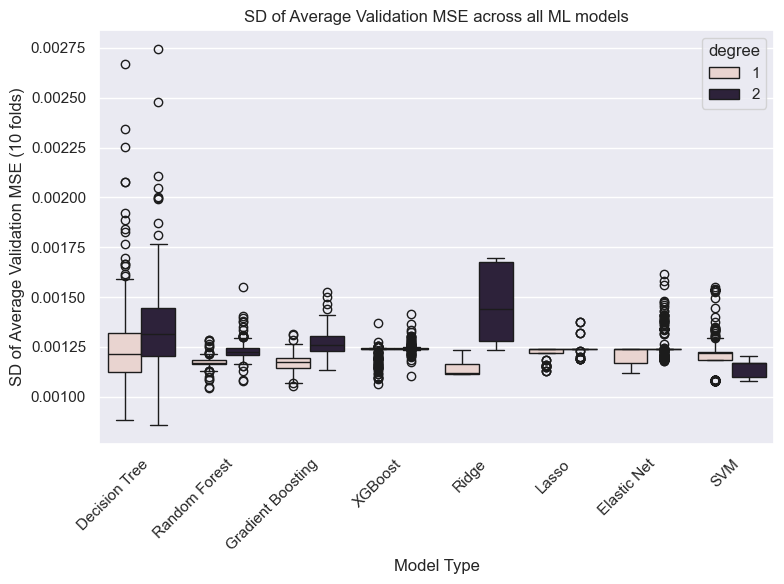

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(final_cv_results, x='model_name', y='std_test_score', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('SD of Average Validation MSE (10 folds)')
ax.set_xlabel('Model Type')
ax.set_title('SD of Average Validation MSE across all ML models')
plt.tight_layout()
plt.savefig('./figures/hp_tuning/all_models_validation_stdev.png')
plt.show()

### Evaluating the best models on the test dataset

In [12]:
# Extracting the best models
best_models_df = final_cv_results[final_cv_results['rank_test_score'] == 1][['model_name', 'degree', 'params', 'mean_test_score']]

**Evaluating the models from the hyperparameter tuning**

In [22]:
# Fitting the best models on the other split
fitted_models_df = best_models_df.copy()
scores_dict = {'train_mse':[], 'train_r2':[], 'test_mse':[], 'test_r2':[]}
for row in best_models_df.itertuples():
    model = models[row.model_name]
    model = model.set_params(**ast.literal_eval(row.params))
    X_train_transform = PolynomialFeatures(degree=row.degree).fit_transform(X_train)
    X_test_transform = PolynomialFeatures(degree=row.degree).fit_transform(X_test)
    model.fit(X_train_transform, y_train)
    y_train_pred = model.predict(X_train_transform)
    y_test_pred = model.predict(X_test_transform)
    scores_dict['train_mse'].append(mean_squared_error(y_true=y_train, y_pred=y_train_pred))
    scores_dict['train_r2'].append(r2_score(y_true=y_train, y_pred=y_train_pred))
    scores_dict['test_mse'].append(mean_squared_error(y_true=y_test, y_pred=y_test_pred))
    scores_dict['test_r2'].append(r2_score(y_true=y_test, y_pred=y_test_pred))
fitted_models_df['train mse'] = scores_dict['train_mse']
fitted_models_df['train R2'] = scores_dict['train_r2']
fitted_models_df['test mse'] = scores_dict['test_mse']
fitted_models_df['test R2'] = scores_dict['test_r2']

fitted_models_unique_df = fitted_models_df.drop_duplicates(subset=['model_name', 'degree', 'test mse', 'test R2'])
    

**Evaluating the Linear models**

In [19]:
# Linear models
linear_models = {'model_name':[], 'degree':[], 'train mse':[], 'train R2':[], 'test mse':[], 'test R2':[]}
for degree in range(1, 5):
    polyreg_model = Pipeline([
                    # ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree)),
                    ('linear', LinearRegression(fit_intercept=False))])
    # fit to an order-3 polynomial data
    polyreg_model = polyreg_model.fit(X_train, y_train)
    y_train_pred = polyreg_model.predict(X_train)
    y_test_pred = polyreg_model.predict(X_test)
    linear_models['model_name'].append('Linear Regression')
    linear_models['degree'].append(degree)
    linear_models['train mse'].append(mean_squared_error(y_true=y_train, y_pred=y_train_pred))
    linear_models['train R2'].append(r2_score(y_true=y_train, y_pred=y_train_pred))
    linear_models['test mse'].append(mean_squared_error(y_true=y_test, y_pred=y_test_pred))
    linear_models['test R2'].append(r2_score(y_true=y_test, y_pred=y_test_pred))

In [23]:
# Joining the results of the hyperparameter tuned models and the linear models
fitted_models_with_linear_df = pd.concat([fitted_models_unique_df, pd.DataFrame(linear_models)])

In [24]:
# Displaying the models with the best Test MSE and R2 values
fitted_models_with_linear_df.sort_values(by='test mse')

,model_name,degree,params,mean_test_score,train mse,train R2,test mse,test R2
6,Lasso Regression,1,"{'max_iter': 1000, 'alpha': 0.0006951927961775...",0.002283,2.169787e-03,0.147025,0.003393,0.116855
81,Elastic Net Regression,1,"{'max_iter': 10000, 'l1_ratio': 0.631578947368...",0.002280,2.188221e-03,0.139779,0.003399,0.115217
101,Ridge Regression,1,"{'solver': 'lsqr', 'alpha': 78.47599703514607}",0.002284,2.165299e-03,0.148790,0.003414,0.111290
0,Linear Regression,1,NaN,NaN,2.148331e-03,0.155460,0.003416,0.110902
92,Elastic Net Regression,2,"{'max_iter': 5000, 'l1_ratio': 0.7894736842105...",0.002273,2.144135e-03,0.157109,0.003431,0.106783
12,Lasso Regression,2,"{'max_iter': 1000, 'alpha': 0.004832930238571752}",0.002289,2.219154e-03,0.127618,0.003515,0.084954
122,Ridge Regression,2,"{'solver': 'lsqr', 'alpha': 1438.44988828766}",0.002373,2.020198e-03,0.205831,0.003555,0.074654
269,Random Forest Regression,2,"{'n_estimators': 200, 'min_samples_split': 3, ...",0.002311,9.584601e-04,0.623215,0.003560,0.073234
7,SVM Regression,1,"{'kernel': 'rbf', 'gamma': 0.001, 'C': 0.5}",0.002581,2.407851e-03,0.053439,0.003579,0.068312
238,Gradient Boosting Regression,2,"{'n_estimators': 120, 'min_samples_split': 5, ...",0.002351,1.854864e-03,0.270826,0.003608,0.060927


### Plotting the performance of the best models on the test set

FixedFormatter should only be used together with FixedLocator


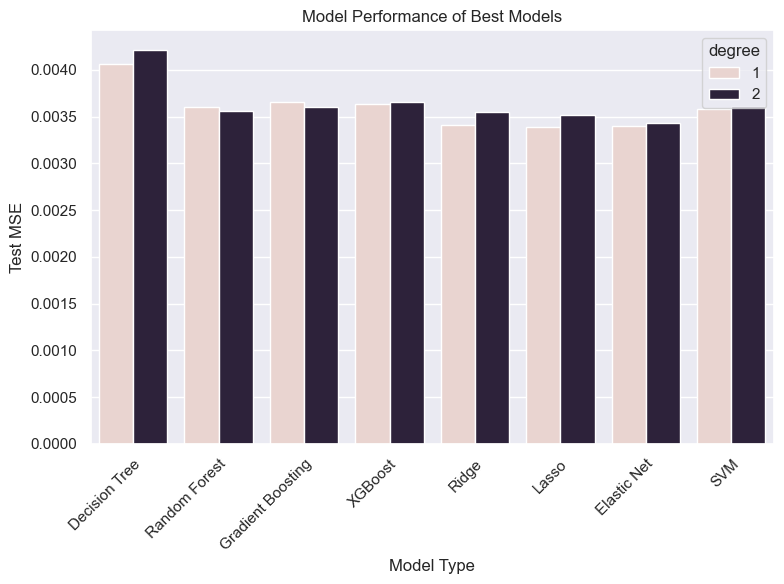

In [25]:
labels = [' '.join(model_name.split(' ')[:-1]) for model_name in final_cv_results['model_name'].unique()] # + ['Linear Regression']
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(fitted_models_unique_df, x='model_name', y='test mse', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Test MSE')
ax.set_xlabel('Model Type')
ax.set_title('Model Performance of Best Models')
plt.tight_layout()
plt.savefig('./figures/hp_tuning/best_models_test_mse.png')
plt.show()

FixedFormatter should only be used together with FixedLocator


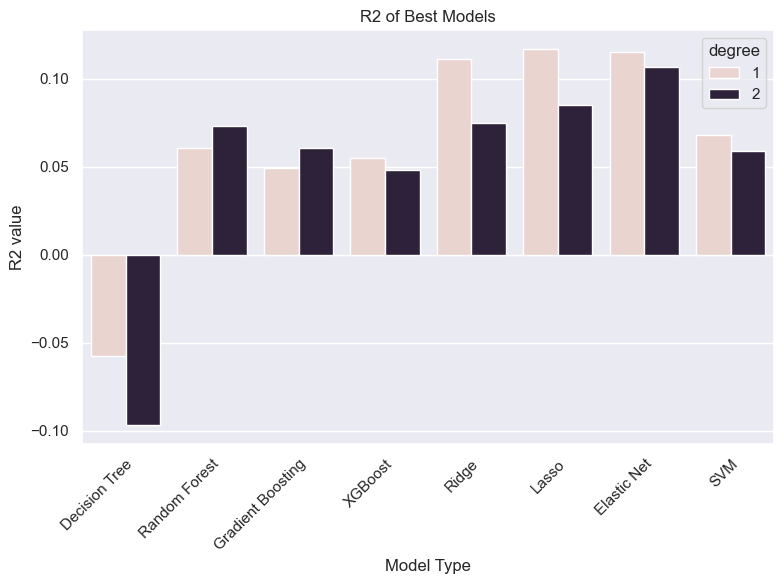

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(fitted_models_unique_df, x='model_name', y='test R2', hue='degree', ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('R2 value')
ax.set_xlabel('Model Type')
ax.set_title('R2 of Best Models')
plt.tight_layout()
plt.savefig('./figures/hp_tuning/best_models_test_R2.png')
plt.show()

### Saving the best model to a pickled object for reloading later

In [43]:
def clean_col_names(df):
    clean_df = df.copy()
    cols = list(clean_df.columns)
    new_cols = [re.sub('^[A-z]{3}__', '', c) for c in cols]
    clean_df.columns = new_cols
    return clean_df

In [44]:
import re
X_train = clean_col_names(X_train)
X_test = clean_col_names(X_test)

# Extract best model parameters
best_model_params = fitted_models_unique_df.sort_values(by='test mse').iloc[0, :]
final_model = models[best_model_params.model_name]
final_model = final_model.set_params(**ast.literal_eval(best_model_params.params))

# Transform data
X_train_transform = PolynomialFeatures(degree=best_model_params.degree).fit_transform(X_train)

# Fit final model
final_model = final_model.fit(X_train, y_train)

# Saving final model to a pickle
import pickle
with open('./data/ml_models/risk_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)


In [62]:
# Fit the shap explainer
explainer = shap.Explainer(final_model.predict, X_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test.sample(1))

# Saving SHAP explainer to pickle object
with open('./data/ml_models/risk_model_shap.pkl', 'wb') as f:
    pickle.dump(explainer, f)

In [61]:
shap.initjs()
shap.force_plot(shap_values)

In [58]:
shap.initjs()
shap.force_plot(shap_values)

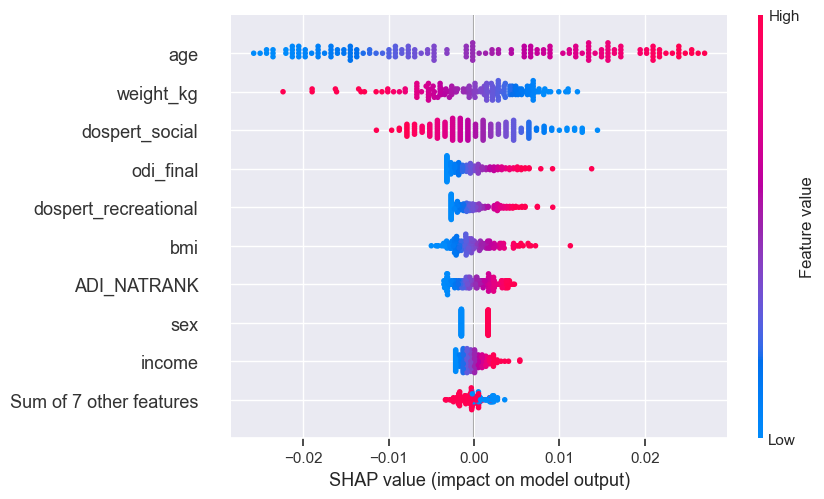

In [47]:
shap.plots.beeswarm(shap_values)

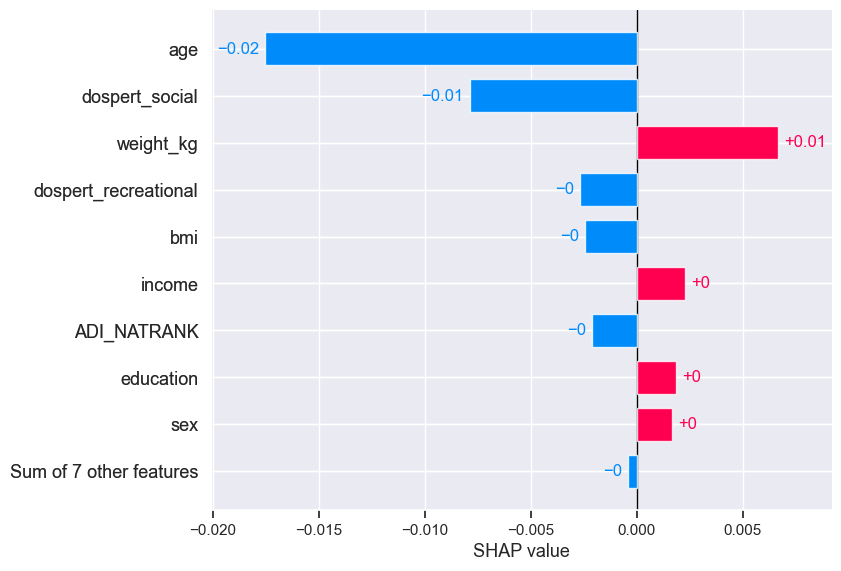

In [49]:
shap.plots.bar(shap_values[0])